In [ ]:
pip install --upgrade pip

In [ ]:
pip install --upgrade scikit-plot --user

# Module 6 Assignment 1: Digit Recognizer

## Data Load

In [103]:
# Loading in packages into environment
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import string as string
import os as os

import time

from collections import defaultdict

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV, RepeatedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score, f1_score,auc
from sklearn.metrics import roc_curve,accuracy_score


sns.set_style("whitegrid")

In [16]:
train = pd.read_csv('train.csv.zip')
test = pd.read_csv('test.csv.zip')
ss = pd.read_csv('sample_submission.csv')

In [44]:
# combining training and test data
df_combined = pd.concat([train, test])

In [45]:
train.shape,test.shape,df_combined.shape, ss.shape

((42000, 785), (28000, 784), (70000, 785), (28000, 2))

## Defining functions that will help our assignment

### 1. Measure time to fit various sklearn functions

In [86]:
#timing to fit
#return fitted model, and dict with model name and time to fit
def fit_with_time(model,X=X,y=y):
  dic = {}
  model_name = type(model).__name__
  t0 = time.time()
  if y is None:
    model.fit(X)
  else:
    model.fit(X,y)
  
  trainTime = time.time()-t0
  
  dic = {
    model_name: [model,trainTime]
  }
  print(f'The model {model_name} took {trainTime: .1f} seconds to train')
  return dic

## Exploratory Data Analysis

### Check if there are missing data, see the shape of the data

In [47]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [49]:
train.isnull().values.any()

False

In [58]:
train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [35]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [50]:
test.isnull().values.any()

False

In [57]:
test.describe()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,...,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.0,28000.0,28000.0,28000.0,28000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.164607,0.073214,0.028036,0.011250,0.006536,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.473293,3.616811,1.813602,1.205211,0.807475,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,253.000000,254.000000,193.000000,187.000000,119.000000,0.0,0.0,0.0,0.0,0.0


### Ploting a sample from train & from test

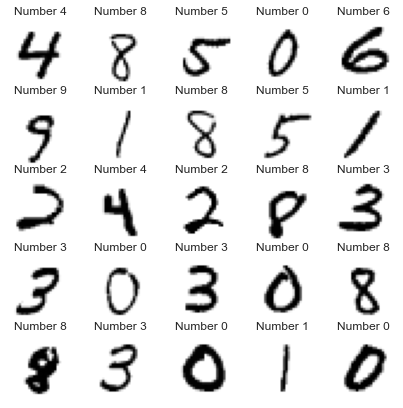

In [60]:
# EDA from Train
fig, axs = plt.subplots(5, 5, figsize = (7, 7))

index_random = np.random.randint(low = 0, high = 42000, size = 5**2)

for i, ax in enumerate(axs.flat):
  ax.imshow(
    train
    .iloc[index_random[i],1:]
    .values
    .reshape(28, 28)
    ,cmap="binary"
  )
  ax.axis('off')
  ax.set_title('Number {}'.format(train.iloc[index_random[i],0]))

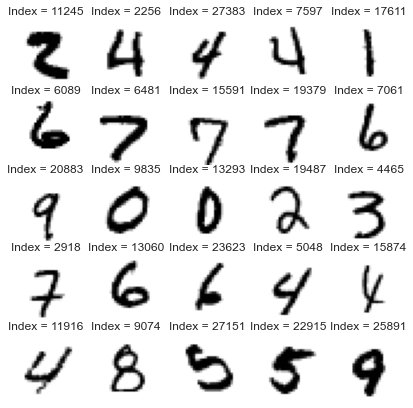

In [65]:
# EDA from Test

fig, axs = plt.subplots(5, 5, figsize = (7, 7))

index_random = np.random.randint(low = 0, high = 28000, size = 5**2)

for i, ax in enumerate(axs.flat):
  ax.imshow(
    test
    .iloc[index_random[i],:]
    .values
    .reshape(28, 28)
    ,cmap="binary"
  )
  ax.axis('off')
  ax.set_title('Index = {}'.format(index_random[i]))

## Assignment requirements:

### Requirement 1 & 2: Random Forest Classifier, Time Recording, Evaluation & Submission

#### 1. Fit a random forest classifier using the full set of explanatory variables and the model training set (csv).

#### 2. Record the time it takes to fit the model and then evaluate the model on the csvdata by submitting to Kaggle.com. Provide your Kaggle.com score and user ID.

In [67]:
# Defining Random Forest Model
model = RandomForestClassifier

In [7]:
X = df_combined.iloc[:42000,1:]
y = df_combined.iloc[:42000,0]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [75]:
rfc = RandomForestClassifier()
#n_jobs = -1

In [78]:
param_distributions = {
  'n_estimators': np.arange(100, 500) # [100,200,400]
  ,'max_features': ['sqrt'] #['sqrt', 'log2']
  ,'max_depth' : np.arange(20,25)#[20,25]
  #,'min_samples_split': [10]
  ,'criterion' : ['entropy']
  ,'random_state' : [42]
  ,'n_jobs' : [-1]
}

#keep entropy

In [81]:
#RandomizedSearchCV
CV_rfc = RandomizedSearchCV(
  estimator = rfc
  ,param_distributions=param_distributions
  ,cv = 5
  ,n_iter=2
  ,random_state=42
)

In [82]:
CV_rfc.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=2,
                   param_distributions={'criterion': ['entropy'],
                                        'max_depth': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                                        'max_features': ['sqrt'],
                                        'n_estimators': array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499]),
                                        'n_jobs': [-1], 'random_state': [42]},
                   random_state=42)

In [83]:
best_param_rdc = CV_rfc.best_params_
best_model_rdc = CV_rfc.best_estimator_

In [84]:
best_param_rdc

{'random_state': 42,
 'n_jobs': -1,
 'n_estimators': 460,
 'max_features': 'sqrt',
 'max_depth': 21,
 'criterion': 'entropy'}

In [326]:
#fit best model and compute time to fit

rfc = RandomForestClassifier(
  random_state = 42
  ,n_jobs= -1
  ,n_estimators=460
  ,max_features ='sqrt'
  ,max_depth= 21
  ,criterion='entropy'
)

best_model = fit_with_time(rfc,X_train,y_train)

The model RandomForestClassifier took  40.7 seconds to train


In [327]:
#get key of the dictionary
key = list(best_model.keys())
key

['RandomForestClassifier']

In [328]:
#Make Predictions
y_pred = best_model[key[0]][0].predict(X_test)

#Evaluate the model
accuracy = accuracy_score(y_test,y_pred)
print(f"Accuracy of the best random forest classifier is: {accuracy: .2f}")

Accuracy of the best random forest classifier is:  0.96


In [330]:
#Predict the results for submission to Kaggle

X_submission = df_combined.iloc[42000:,1:]
y_submission = best_model[key[0]][0].predict(X_submission)

In [335]:
#storing results in a dictionary models to organize all our discoveries and submissions

#get key of the dictionary
key = list(best_model.keys())

# Append to our model dictionary
models = {}

#adding to existing dictionary model
models.setdefault(key[0],[])
models[key[0]].append(best_model[key[0]])
models[key[0]].append(y_submission)

In [336]:
best_model[key[0]]

[RandomForestClassifier(criterion='entropy', max_depth=21, n_estimators=460,
                        n_jobs=-1, random_state=42),
 40.657153844833374]

In [339]:
np.shape(models[key[0]])

(2,)

In [120]:
submission_df = pd.read_csv('sample_submission.csv')
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   ImageId  28000 non-null  int64
 1   Label    28000 non-null  int64
dtypes: int64(2)
memory usage: 437.6 KB


In [340]:
for model_desc, list_in_dic in models.items():
  submission_df.Label = list_in_dic[1]
  submission_df.to_csv(
    'MSDS422_assignment_06_'+model_desc+'.csv'
    ,index=False
  )
print('You can submit all models to Kaggle website! :-)')

You can submit all models to Kaggle website! :-)


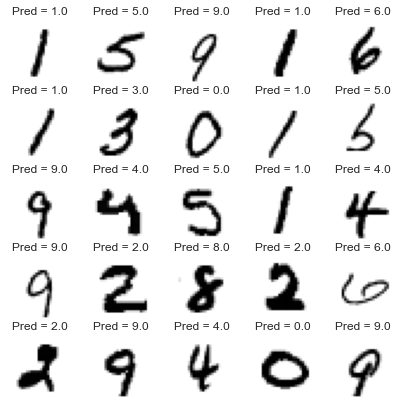

In [341]:
# Eye-balling goodness of predictions

fig, axs = plt.subplots(5, 5, figsize = (7, 7))

index_random = np.random.randint(low = 0, high = 28000, size = 5**2)

for i, ax in enumerate(axs.flat):
  ax.imshow(
    X_submission
    .iloc[index_random[i],:]
    .values
    .reshape(28, 28)
    ,cmap="binary"
  )
  ax.axis('off')
  ax.set_title('Pred = {}'.format(y_submission[index_random[i]]))

### Requirements 3 & 4: Combining the training and test data + Recording PCA runtime  

In [356]:
from sklearn.decomposition import PCA

X = df_combined.iloc[:42000,1:]

pca = PCA(n_components=0.95) #95% of variability
pca = fit_with_time(pca,X)

#get key
key = list(pca.keys())

dim_pca = pca[key[0]][0].n_components_

print(f'\nNumber of dimensions : {dim_pca}')

The model PCA took  3.4 seconds to train

Number of dimensions : 154


In [357]:
#Using pipeline to train the model
#first, using PCA, and then Random Forest using the paramters found earlier
from sklearn.pipeline import make_pipeline

clf = make_pipeline(
  PCA(n_components=dim_pca,random_state=42)
  ,RandomForestClassifier(random_state=42
                          ,n_estimators=460
                          ,max_features='sqrt'
                          ,max_depth = 21
                          ,criterion = 'entropy'
                         )
)

In [ ]:
#fitting model and recording time
pca_rfc = fit_with_time(clf,X_train, y_train)

In [358]:
#get key of the dictionary
key = list(pca_rfc.keys())

#Make Predictions
y_pred = pca_rfc[key[0]][0].predict(X_test)

#Evaluate the model
accuracy = accuracy_score(y_test,y_pred)
print(f"Accuracy of the pca with random forest class is: {accuracy: .2f}")

The model Pipeline took  776.0 seconds to train
Accuracy of the pca with random forest class is:  0.94


In [359]:
#Predict the results for submission to Kaggle

X_submission = df_combined.iloc[42000:,1:]
y_submission = pca_rfc[key[0]][0].predict(X_submission)

In [362]:
#adding to our model dictionary
models.setdefault(key[0],[])
models[key[0]].append(pca_rfc[key[0]])
models[key[0]].append(y_submission)

In [364]:
#inspect dictionary
models

{'RandomForestClassifier': [[RandomForestClassifier(criterion='entropy', max_depth=21, n_estimators=460,
                          n_jobs=-1, random_state=42),
   40.657153844833374],
  array([2., 0., 9., ..., 3., 9., 2.])],
 'Pipeline': [[Pipeline(steps=[('pca', PCA(n_components=154, random_state=42)),
                   ('randomforestclassifier',
                    RandomForestClassifier(criterion='entropy', max_depth=21,
                                           n_estimators=460, random_state=42))]),
   775.9835307598114],
  array([2., 0., 9., ..., 3., 9., 2.])]}

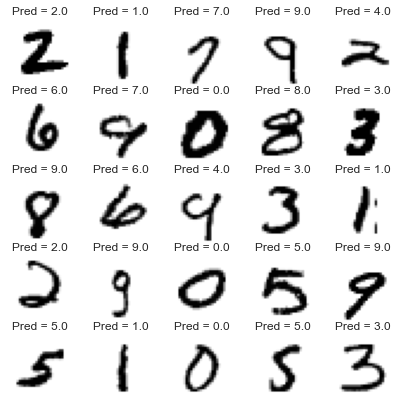

In [360]:
# Eye-balling goodness of predictions

fig, axs = plt.subplots(5, 5, figsize = (7, 7))

index_random = np.random.randint(low = 0, high = 28000, size = 5**2)

for i, ax in enumerate(axs.flat):
  ax.imshow(
    X_submission
    .iloc[index_random[i],:]
    .values
    .reshape(28, 28)
    ,cmap="binary"
  )
  ax.axis('off')
  ax.set_title('Pred = {}'.format(y_submission[index_random[i]]))

#### 7. Use k-means clustering to group MNIST observations into 1 of 10 categories and then assign labels. 

In [451]:
X.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [452]:
X.values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [459]:
pip install threadpoolctl --upgrade --user

  Using cached threadpoolctl-3.2.0-py3-none-any.whl.metadata (10.0 kB)
Using cached threadpoolctl-3.2.0-py3-none-any.whl (15 kB)
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [14]:
x = np.array([[[0], [1], [2]]])
np.squeeze(x)

array([0, 1, 2])

In [9]:
from sklearn.cluster import MiniBatchKMeans

n_digits = len(np.unique(y_test))
print(n_digits)
# Initialize KMeans model

kmeans = MiniBatchKMeans(n_clusters = n_digits)

# Fit the model to the training data
kmeans.fit(X)
kmeans.labels_

10


C:\Users\HHolanda\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


array([8, 7, 0, ..., 1, 3, 5])

In [12]:
def infer_cluster_labels(kmeans, actual_labels):
  inferred_labels = {}
  for i in range(kmeans.n_clusters):
    labels = []
    index = np.where(kmeans.labels_ == i)
    # append actual labels for each point in cluster
    labels.append(actual_labels[index])
    
    # determine most common label
    if len(labels[0]) == 1:
      counts = np.bincount(labels[0])
    

# empty array of len(X)
def infer_data_labels(X_labels, cluster_labels):
  predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
